In [1]:
import matplotlib.pyplot as plt
import numpy as np
def kde(data, n=2**14, MIN=None, MAX=None, plot=False, label = []):
  import numpy as np
  from scipy import optimize
	
	# Auxiliary Functions 
  #==========================================================================  
  def fixed_point(t,N,I,a2):
    # This implements the function t-zeta*gamma^[l](t)
    l=7
    f=2*np.pi**(2*l) * sum(I**l*a2*np.exp(-I*np.pi**2*t))
        
    for s in range(l-1,1,-1):
      K0    = np.prod(range(1,2*s,2))/np.sqrt(2*np.pi)
      const = (1+(1/2)**(s+1/2))/3
      time  = (2*const*K0/N/f)**(2/(3+2*s))
      f     = 2*np.pi**(2*s)*sum(I**s*a2*np.exp(-I*np.pi**2*time)) 
    
    return t-(2*N*np.sqrt(np.pi)*f)**(-2/5)
    #==========================================================================  
  def dct1d(data):
    # computes the discrete cosine transform of the column vector data
    nrows = len(data)
    # Compute weights to multiply DFT coefficients
    weight = 2*(np.exp(-1j*np.array(range(1,nrows))*np.pi/(2*nrows)))
    weight = np.append(1,weight)
    # Re-order the elements of the columns of x
    data = np.append(data[::2],data[:0:-2])
    # Multiply FFT by weights:
    data = (weight*np.fft.fft(data)).real
		
    return data
    #==========================================================================  
  def idct1d(data):
	  # computes the discrete cosine transform of the column vector data
    nrows = len(data) 
		# Compute weights to multiply DFT coefficients
    weights = nrows*np.exp(1j*(np.arange(nrows))*np.pi/(2*nrows))
		# Multiply FFT by weights:
    data = np.real(np.fft.ifft(weights * data))
    # Re-order the elements of the columns of x
    output = np.arange(nrows, dtype = 'd')
    output[::2] = data[0:int(nrows/2)]
    output[1::2] = data[:int(nrows/2)-1:-1]
		
		#   Reference:
		#     A. K. Jain, "Fundamentals of Digital Image
		#     Processing", pp. 150-153.
		
    return output
		
  # Main Function
  #===========================================================================  
  data = np.array(data)   #Make data a numpy array 
    
  n=int(2**np.ceil(np.log2(n))) #round up n to the next power of 2;
    
  #define the default  interval [MIN,MAX]
    
  if MAX == None or MIN == None:
    minimum = min(data)
    maximum = max(data)
    Range   = maximum - minimum
    
    if MAX == None:
      MAX=maximum+Range/10
        
    if MIN == None:
      MIN=minimum-Range/10
       

	# set up the grid over which the density estimate is computed;
  R=MAX-MIN; dx=R/(n-1)
  xmesh=np.arange(MIN,MAX+dx,dx, dtype = 'd')
  bins = np.append(xmesh, xmesh[-1])
  N=len(np.unique(data))
	# bin the data uniformly using the grid defined above;
  initial_data= np.histogram(data, bins = bins)[0]/N
  initial_data=initial_data/sum(initial_data)

	# discrete cosine transform of initial data
  a=dct1d(initial_data)

	# now compute the optimal bandwidth^2 using the referenced method
  I=np.arange(1,n,dtype = "d")**2; a2=(a[1:]/2)**2

	# solve the equation t=zeta*gamma^[5](t)
  t_star = optimize.root(lambda t: fixed_point(t,N,I,a2), 0.05)
  if t_star.success == False:
    t_star = 0.28*N**(-2/5)
  else: 
    t_star = t_star.x
	# smooth the discrete cosine transform of initial data using t_star
  a_t=a*np.exp(-np.arange(0,n, dtype = "d")**2*np.pi**2*t_star/2)
    
	# now apply the inverse discrete cosine transform
  density=idct1d(a_t)/R
	# take the rescaling of the data into account
  bandwidth=np.sqrt(t_star)*R
    
    # for cdf estimation
  f=2*np.pi**2*sum(I*a2*np.exp(-I*np.pi**2*t_star))
  t_cdf=(np.sqrt(np.pi)*f*N)**(-2/3)
	# now get values of cdf on grid points using IDCT and cumsum function
  a_cdf=a*np.exp(-np.arange(0,n,dtype="d")**2*np.pi**2*t_cdf/2)
  cdf=np.cumsum(idct1d(a_cdf))*(dx/R)
	#take the rescaling into account if the bandwidth value is required
  bandwidth_cdf=np.sqrt(t_cdf)*R

  if plot==True:
    if label: 
      plt.plot(xmesh, density, label = label)
      plt.legend()
    else: 
      plt.plot(xmesh, density)
      plt.ylim(bottom=0)  
      

  return [bandwidth,density,xmesh,cdf]

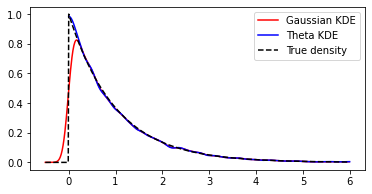

In [2]:
h   = 0.1; h2 = h**2; c=1/np.sqrt(2*np.pi)/h #Hằng số
phi = lambda x,x0: np.exp(-(x-x0)**2/(2*h2)) #Unscaled Kernel
f   = lambda x: np.exp(-x)*(x >= 0) # True PDF 
n = 10**4 # Sample Size
x = -np.log(np.random.uniform(size=n))# Generate Data via IT method
xx = np.arange(-0.5,6,0.01, dtype = "d")# Plot Range
phis = np.zeros(len(xx))
for i in range(0,n):
    phis = phis + phi(xx,x[i])
phis = c*phis/n

plt.figure(figsize=[6,3])

plt.plot(xx,phis,'r')# Plot Gaussian KDE

[bandwidth,density,xmesh,cdf] = kde(x,2**12,0,max(x))

idx = (xmesh <= 6)
plt.plot(xmesh[idx],density[idx],'b')# Plot Theta KDE
plt.plot(xx,f(xx),'k--')# Plot True PDF
plt.legend(['Gaussian KDE','Theta KDE', 'True density'])
plt.savefig('gausthetakde.pdf',format='pdf')


Ví dụ 4.8:

Cách 1:

In [3]:
import numpy as np 
from scipy.spatial.distance import cdist

def update_distances(D,i,j, sizes): # tính toán khoảng cách cho cụm đã hợp nhất
    n = D.shape[0]     
    d = np.inf * np.ones(n+1)
    for k in range(n): # cập nhật khoảng cách
       d[k] = ((sizes[i]+sizes[k])*D[i,k] + 
       (sizes[j]+sizes[k])*D[j,k] - 
       sizes[k]*D[i,j])/(sizes[i] + sizes[j] + sizes[k])
                   
    infs =  np.inf * np.ones(n) # mảng vô cực
    D[i,:],D[:,i],D[j,:],D[:,j] =  infs,infs,infs,infs # 
    new_D = np.inf * np.ones((n+1,n+1))
    new_D[0:n,0:n] = D # sao chép ma trận cũ vào new_D
    new_D[-1,:], new_D[:,-1] = d,d # thêm hàng và cột mới
    return new_D
            
def agg_cluster(X):  
    n = X.shape[0]
    sizes = np.ones(n)
    D = cdist(X, X,metric = 'sqeuclidean')   # khởi tạo ma trận khoảng cách
    np.fill_diagonal(D, np.inf * np.ones(D.shape[0]))    
    Z = np.zeros((n-1,4))  #ma trận liên kết mã hóa cây phân cấp
    for t in range(n-1):
        i,j = np.unravel_index(D.argmin(), D.shape) # cặp giảm thiểu
        sizes = np.append(sizes, sizes[i] + sizes[j])
        Z[t,:]=np.array([i, j, np.sqrt(D[i,j]), sizes[-1]]) 
        D = update_distances(D, i,j, sizes)  # cập nhận lại ma trận khoảng cách
    return Z   

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',

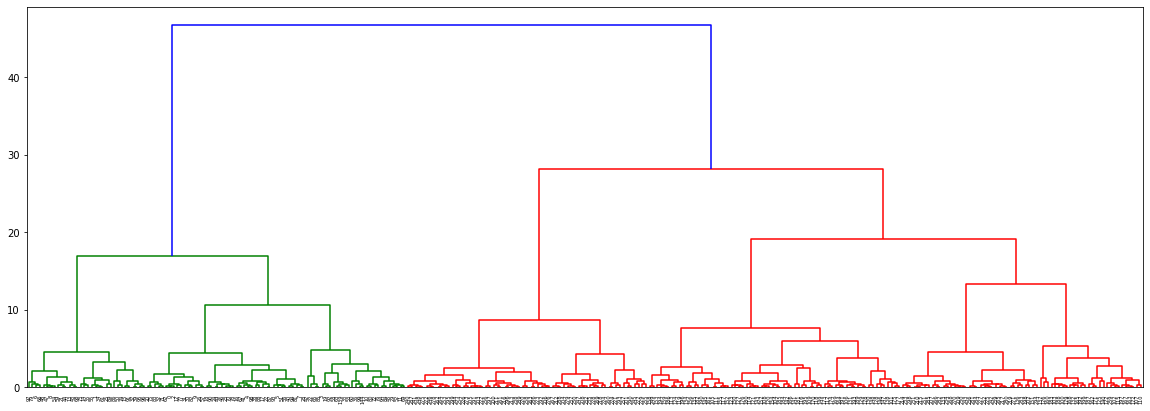

In [4]:
import scipy.cluster.hierarchy as h 
#vẽ biểu đồ dendrogram
X = np.genfromtxt('clusterdata.csv',delimiter=',') # đọc dữ liệu
Z = agg_cluster(X)  # Hình thành ma trận liên kết
plt.figure(figsize=(20, 7))
h.dendrogram(Z) #tạo ra biểu đồ dendrogram(Z)

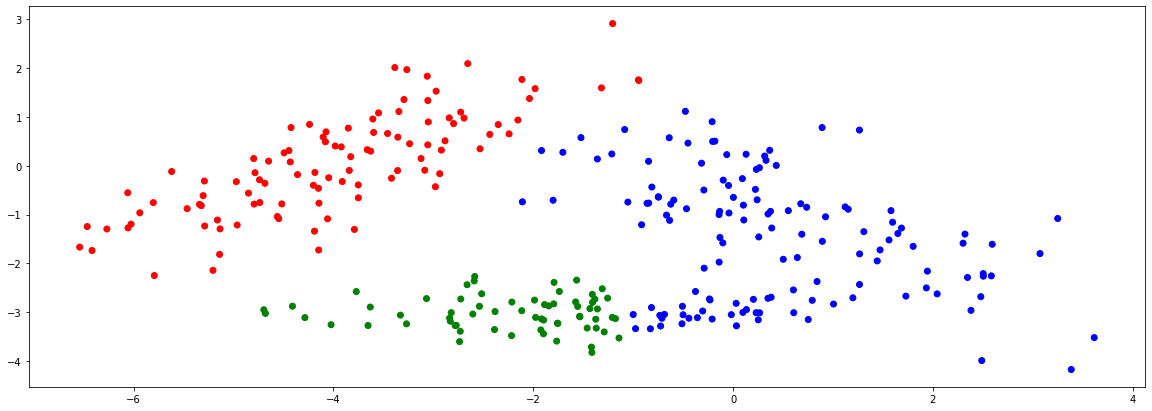

In [5]:
#Biểu đồ hóa dữ liệu
cl = h.fcluster(Z, criterion = 'maxclust', t=3) 
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 7)), plt.clf()
cols = ['red','green','blue']
colors = [cols[i-1] for i in cl]
plt.scatter(X[:,0], X[:,1],c=colors)
plt.show()

Cách 2


In [ ]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import numpy as np

In [ ]:
data = pd.read_csv("clusterdata.csv")
print(data.shape)


(299, 2)


In [ ]:
#Chuẩn hóa dữ liệu để loại bỏ sự khác biệt về mặt đơn vị giữa các chiều.
std = MinMaxScaler()
X_std = std.fit_transform(data)

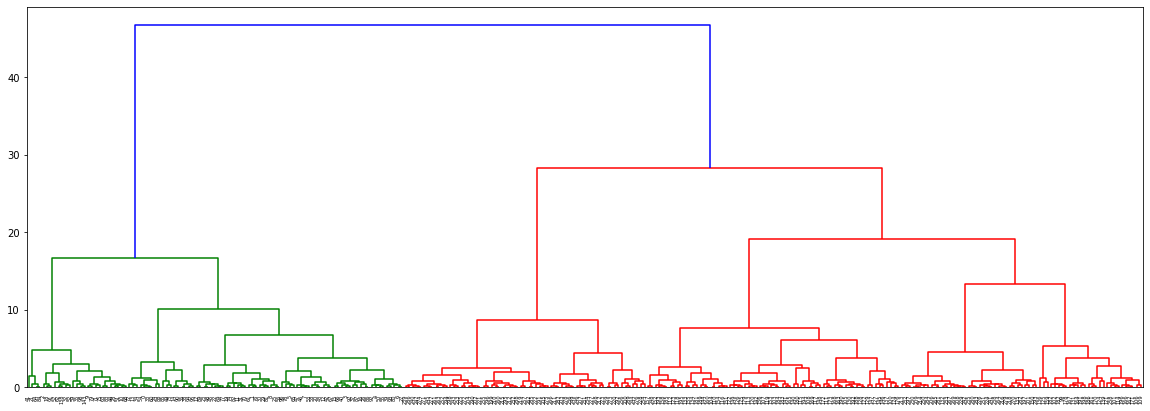

In [ ]:
plt.figure(figsize=(20, 7))
dend = shc.dendrogram(shc.linkage(data, method = 'ward'))

In [ ]:
AgglomerativeClustering(
  n_clusters=2,  
  affinity='euclidean',
  compute_full_tree='auto', 
  linkage='ward', 
  distance_threshold=None, 
  compute_distances=False)

AgglomerativeClustering()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = cluster.fit_predict(X_std)

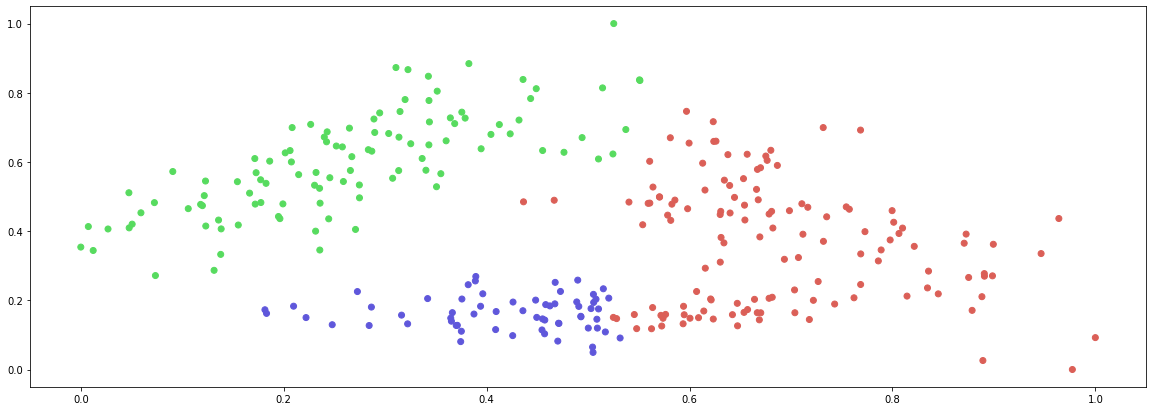

In [ ]:
def _plot_kmean_scatter(X, labels):
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))
    # vẽ biểu đồ scatter
    fig = plt.figure(figsize=(20, 7))
    sc = plt.scatter(X[:,0], X[:,1],c=palette[labels.astype(np.int)])
_plot_kmean_scatter(X_std, labels)

Ví dụ: 4.9

In [ ]:
import numpy as np
from numpy import genfromtxt
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

def S(x,D):
    V1 = np.where(x==0)[0] # {V1,V2} là phân vùng
    V2 = np.where(x==1)[0]
    tmp = D[V1]
    tmp = tmp[:,V2]
    return np.mean(tmp) 

def maxcut(D,N,eps,rho,alpha):
    n = D.shape[1]
    Ne = int(rho*N)
    p = 1/2*np.ones(n) 
    p[0] = 1.0
    while (np.max(np.minimum(p,np.subtract(1,p))) > eps):
        x = np.array(np.random.uniform(0,1, (N,n))<=p, dtype=np.int64)
        sx = np.zeros(N)
        for i in range(N):
            sx[i] = S(x[i],D)
        
        sortSX = np.flip(np.argsort(sx))
        elIds = sortSX[0:Ne]
        elites = x[elIds]
        pnew = np.mean(elites, axis=0)
        p = alpha*pnew + (1.0-alpha)*p

    return np.round(p)

giá trị cắt giảm  4.625207676517948


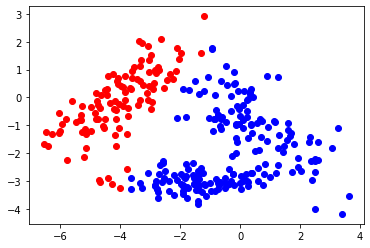

In [ ]:
Xmat = genfromtxt('clusterdata.csv', delimiter=',')
n = Xmat.shape[0]
D = squareform(pdist(Xmat))
# CE
pout = maxcut(D,1000,10**-2,0.1, 0.9);
cutval = S(pout,D)
print("giá trị cắt giảm ",cutval)
#plot
V1 = np.where(pout==0)[0]
xblue = Xmat[V1]
V2 = np.where(pout==1)[0]
xred = Xmat[V2]
plt.scatter(xblue[:,0],xblue[:,1], c="blue")
plt.scatter(xred[:,0],xred[:,1], c="red")